##### 샘플 데이터

In [1]:
import pandas as pd
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [39]:
with open("클러스터링 결과.pkl", "rb") as file :
    df = pickle.load(file)
df.head()

,Date,Name,Score,Review,like,tagged_review,vector,cluster
0,2020년 1월 24일,홍현주,3,시스템에어컨 5대 연결해서 원격제어로 사용중입니다. 에어컨 기능은 공기청정기능까지 ...,2,"[시스템, 에어컨, 대다, 연결하다, 격, 제어, 사용, 에어컨, 기능, 공기청정기...","[-0.34670252, 0.34725657, -0.1817569, -0.05553...",3
1,2020년 1월 7일,쌤쌤,3,인덕션 제어용으로 사용하려고 하는데 끄는 전용인건 좋은데 원격제어기능이 계속 꺼져야...,0,"[인덕션, 제어, 용, 사용, 끄다, 전용, 건, 좋다, 격, 제어기, 능이, 계속...","[-0.2936117, 0.10722984, -0.37230322, -0.84482...",4
2,2020년 1월 8일,Nicholas Jun,1,위례 사는 신혼 부부입니다. TV랑 공기청정기는 잘 연동시켰습니다. 오래 걸리지도 ...,0,"[위례, 살다, 신혼, 부부, 공기청정기, 자다, 연동, 걸리다, 않다, 문제, 김...","[-0.026138704, 0.4423121, -0.4001457, 0.004646...",1
3,2020년 1월 24일,Hong KIM,1,세탁기 된다고 해서 연결했는데 놀라울 정도로 세상 쓰레기에요. 연결은 번거롭고 사용...,0,"[세탁기, 연결하다, 정도, 세상, 쓰레기, 연결, 번거롭다, 사용성, 까다롭다, ...","[-0.23055202, -0.0485264, -0.19324352, -0.1418...",2
4,2020년 1월 22일,byung-hyun cho,3,건조완료후 에어리플레쉬를 원격으로도 추가할 수 있도록 건조완료후 원격제어를 off하...,0,"[건조, 완료, 후, 에어, 리플, 레쉬, 원격, 추가, 수, 건조, 완료, 후, ...","[-0.1028823, 0.37095952, -0.093728304, -0.4726...",5


# ◆ 1. LDA를 위한 데이터 전처리
* 1.1. 전체 단어의 사전 만들고 각 문서에 매칭하기
    > 단어들이 문서에 얼마나 위치해 있는지 분포를 파악해야하기 때문에 분석할 전체 데이터 대상으로
    사용된 단어의 사전을 생성해야한다,


In [38]:
# LDA 모델 그리기 위해 필요한 것들
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary

### 1.1 전체 단어의 사전 만들고 각 문서에 매칭하기

In [4]:
df_cluster0 = df[df['cluster'] == 0]
df_cluster0

,Date,Name,Score,Review,like,tagged_review,vector,cluster
11,2019년 12월 18일,이성우,1,11년차 SW 엔지니어 입니다. 정말 한심하게 보이네요. 업데이트 하고 약관동의 다...,5,"[엔지니어, 정말, 한심하다, 보이다, 업데이트, 약관, 동의, 다시, 제품, 사라...","[-0.25042018, -0.8012963, 0.8671157, 0.4586773...",0
25,2019년 12월 17일,임지은,1,공기청정기 등록하려고하니 1단계 제품연결준비제품의 버튼을 3초이상눌러 어쩌구 하는 ...,6,"[공기청정기, 등록, 단계, 제품, 연결, 준비, 제품, 버튼, 어쩌구, 단계, 넘...","[-0.45713553, -0.4375362, -0.009262105, -0.031...",0
40,2020년 1월 11일,아름다운 세상,1,네트워크 연결이 원할하지 않습니다. 언제 고칠 껀가요!!! 저거 뜨면서 앱이 꺼져서...,0,"[네트워크, 연결, 할하, 않다, 고치다, 껀가, 거, 뜨다, 앱, 꺼지다, 쓸다,...","[0.009318334, 0.09919301, 0.055767186, 0.04913...",0
45,2019년 12월 7일,이원미,1,서버응답이 안돼요모피코스 돌려야하는데안되어서 요즘 스터일러 돌일일이 없습니다.건조기...,0,"[서버, 응답, 돼다, 모피, 코스, 돌리다, 안되다, 요즘, 스터일러, 돌, 일일...","[-0.32195476, -0.44350228, 0.24547465, -0.1923...",0
63,2019년 11월 29일,김창현,3,서버 연결 오류라고 계속뜨는데 음.... 끝나면 알람은오고 조치를하셔야 할거같은데요...,6,"[서버, 연결, 오류, 계속, 뜨다, 음, 끝나다, 알람, 오다, 조치, 아예, 먹...","[-0.042001866, 0.21800995, -0.17948823, -0.206...",0
...,...,...,...,...,...,...,...,...
6133,2017년 7월 22일,gustav kim,1,조그만한 startup 회사에서 만든 것도 아닌텐데 5Gh 공유기여서 안된다고하네요...,0,"[조그만, 회사, 만들다, 아니다, 공유기, 안되다, 공유기, 오다, 지원, 엘지,...","[-0.17060855, -0.8576732, 0.10578959, 0.002602...",0
6147,2018년 7월 25일,Google 사용자,1,속터지네요..엘지유플러스 인터넷에서 가져온 공유기에 2.4g뻔히 적혀있는 아이피로 ...,1,"[속, 터지다, 엘지, 유플러스, 인터넷, 가져오다, 공유기, 뻔하다, 적히다, 아...","[-0.7971194, 0.1279153, -0.59796524, 0.6166836...",0
6179,2018년 8월 16일,조은희,1,에러코드506으로 나타나며 앱설치가 않됩니다,0,"[에러, 코드, 나타나다, 앱, 설치, 않다]","[-0.1069369, -0.065903746, 0.026938159, -0.024...",0
6181,2017년 10월 7일,이원환,1,실행이 안됩니다. 말그대로 아무반응이없어요 몇번을 재설치하고 폰도 다시 껏다 켜보고...,0,"[실행, 안되다, 말, 그대로, 반응, 없다, 몇번, 재, 설치, 폰, 다시, 껏,...","[-0.11716833, -0.12752123, -0.030093448, -0.08...",0


In [5]:
all_documents = list(df_cluster0['tagged_review'])

dictionary = Dictionary(all_documents)
dictionary

In [6]:
dictionary.token2id

{'개': 0,
 '개발': 1,
 '건조기': 2,
 '계시다': 3,
 '계정': 4,
 '공기청정기': 5,
 '그대로': 6,
 '기기': 7,
 '꼬이다': 8,
 '나오다': 9,
 '낭비': 10,
 '냉장고': 11,
 '다시': 12,
 '데리다': 13,
 '데이터': 14,
 '돈': 15,
 '동의': 16,
 '등록': 17,
 '만들다': 18,
 '많다': 19,
 '명': 20,
 '바뀌다': 21,
 '받다': 22,
 '보이다': 23,
 '복원': 24,
 '사라지다': 25,
 '살아나다': 26,
 '상태': 27,
 '세탁기': 28,
 '소리': 29,
 '식': 30,
 '식이': 31,
 '쌓이다': 32,
 '아니다': 33,
 '안되다': 34,
 '약관': 35,
 '업데이트': 36,
 '에어컨': 37,
 '엔지니어': 38,
 '연결': 39,
 '연동': 40,
 '예전': 41,
 '외': 42,
 '요즘': 43,
 '유니크': 44,
 '이렇다': 45,
 '이르다': 46,
 '인력': 47,
 '일해': 48,
 '정말': 49,
 '정보': 50,
 '제품': 51,
 '중복': 52,
 '쥬니어': 53,
 '지금': 54,
 '첫': 55,
 '케어': 56,
 '퓨리': 57,
 '한심하다': 58,
 '합': 59,
 '협업': 60,
 '그냥': 61,
 '넘어가다': 62,
 '단계': 63,
 '더': 64,
 '데': 65,
 '뭐': 66,
 '버튼': 67,
 '보이': 68,
 '사용': 69,
 '어쩌구': 70,
 '어플': 71,
 '없다': 72,
 '엘지': 73,
 '잡다': 74,
 '잡수다': 75,
 '준비': 76,
 '크다': 77,
 '편하다': 78,
 '폰': 79,
 '하라': 80,
 '화면': 81,
 '확률': 82,
 '거': 83,
 '고치다': 84,
 '꺼지다': 85,
 '껀가': 86,
 '네트워크': 87,
 '뜨다': 88,
 

In [10]:
corpus = []
for doc in all_documents :
    corpus.append(dictionary.doc2bow(doc))
corpus # (id값, 빈도수)
len(corpus) # doc 값과 동일

306

# ◆ 2. LDA모델 만들기
* 2.1 LDA 기본 모델 만들기
* 2.2 LDA 토픽개수 선정
* 2.3 선정한 토픽 개수로 Action 넘버 매칭

### 2.1 LDA 기본 모델 만들기

In [11]:
topic_num = 3 # 임의로 가정

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = topic_num, id2word =dictionary ) # 코드 불러오는 모델


In [12]:
lda_model.print_topics(num_words = 5) # 3개의 토픽에 대하여 5개의 주제 단어 정렬, 정렬순서는 큰 숫자 부터

[(0, '0.022*"안되다" + 0.019*"연결" + 0.018*"에어컨" + 0.016*"없다" + 0.015*"서버"'),
 (1, '0.024*"앱" + 0.023*"안되다" + 0.018*"연결" + 0.017*"없다" + 0.012*"사용"'),
 (2, '0.018*"앱" + 0.015*"등록" + 0.014*"어플" + 0.012*"안되다" + 0.010*"연결"')]

In [13]:
# 하나 뽑고 싶을 때
lda_model.get_document_topics(corpus)[0] # 첫 번째 문서에 대한 값 -> 1번 토픽일 것이다 -> 데이터에 새로운 열로 붙이기

[(0, 0.266183), (1, 0.7289347)]

In [14]:
for i in range(len(corpus)) : 
    print(lda_model.get_document_topics(corpus)[i])

[(0, 0.26634404), (1, 0.7287737)]
[(0, 0.01102138), (1, 0.50201863), (2, 0.48695996)]
[(0, 0.031522833), (1, 0.9403851), (2, 0.02809208)]
[(0, 0.013981423), (1, 0.9714508), (2, 0.01456777)]
[(0, 0.020581936), (1, 0.95614636), (2, 0.023271717)]
[(0, 0.027468175), (1, 0.028184775), (2, 0.9443471)]
[(0, 0.057525944), (1, 0.8899882), (2, 0.05248587)]
[(0, 0.932162), (1, 0.0360674), (2, 0.031770594)]
[(0, 0.043287102), (1, 0.049096663), (2, 0.90761626)]
[(0, 0.92711574), (1, 0.037219375), (2, 0.035664853)]
[(0, 0.04848862), (1, 0.04835153), (2, 0.90315986)]
[(0, 0.031761523), (1, 0.93756384), (2, 0.030674666)]
[(0, 0.015111274), (1, 0.37294596), (2, 0.61194277)]
[(0, 0.97240555), (1, 0.013977648), (2, 0.013616819)]
[(0, 0.04810306), (1, 0.9067792), (2, 0.04511774)]
[(0, 0.012238279), (1, 0.9747357), (2, 0.013026046)]
[(0, 0.7018473), (1, 0.012171494), (2, 0.28598124)]
[(0, 0.97929496), (1, 0.010328145), (2, 0.01037686)]
[(0, 0.97065943), (1, 0.015301766), (2, 0.014038788)]
[(2, 0.98291403)]

### 2.2 LDA 토픽개수 선정
* cohearence & perplexcity

In [15]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np

In [17]:
perplex_score = lda_model.log_perplexity(corpus)
perplex_score

-6.891923656401433

In [18]:
coherence_model = CoherenceModel(model = lda_model, texts = all_documents, dictionary = dictionary, topn = 3)
coherence_model.get_coherence()

0.6249424383306229

> 2.2.1 Perplexity 그래프 만들기

In [19]:
perplexity_values = []
for i in range(2, 10) :
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = i, id2word = dictionary)
    perp_v = lda_model.log_perplexity(corpus)
    perplexity_values.append(perp_v)
perplexity_values

[-6.802893828662962,
 -6.902234826238019,
 -6.996371561317563,
 -7.057279653435291,
 -7.094133745130074,
 -7.189247124765289,
 -7.212598928537928,
 -7.293121204798371]

Text(0, 0.5, 'perplexity score')

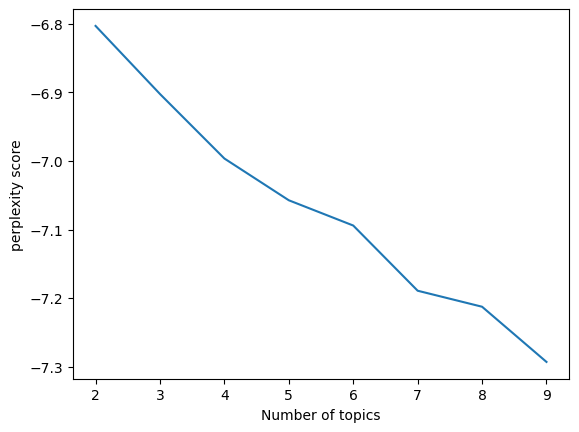

In [20]:
# 축 설정
x = range(2, 10)
plt.plot(x, perplexity_values)
plt.xlabel('Number of topics')
plt.ylabel('perplexity score')

> 2.2.1 Cohearence 그래프 만들기

In [22]:
coherence_values = []
for i in range(2, 10) :
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = i, id2word = dictionary)
    coherence_model = CoherenceModel(model = lda_model, texts = all_documents, dictionary = dictionary, topn = i)
    coherence_score = coherence_model.get_coherence()
    coherence_values.append(coherence_score)
coherence_values

[0.765696758945966,
 0.6583155402113213,
 0.6160251876800232,
 0.5448555145339076,
 0.5394927496657762,
 0.4881449204693916,
 0.4649229606480979,
 0.46295019948167265]

Text(0, 0.5, 'Coherence score')

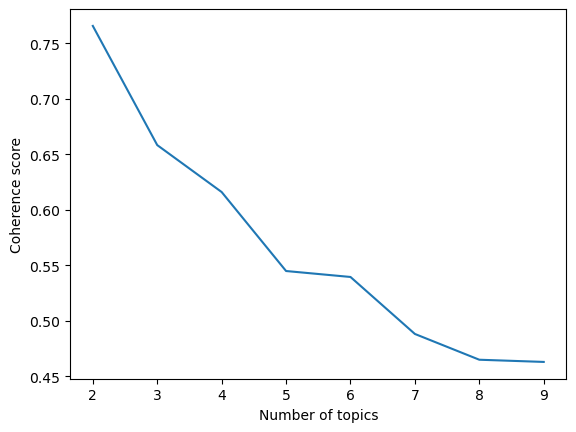

In [23]:
x = range(2, 10)
plt.plot(x, coherence_values)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')

### 2.3 선정한 토픽 개수로 Action 넘버 매칭

In [26]:
topic_n = 5
lda_model = gensim.models.LdaModel(corpus = corpus, num_topics = topic_n, id2word = dictionary, random_state = 1, passes = 5) 
# random_state : 돌릴 때마다 다른 값이 나오는데 항상 같은 값을 나오게 하는 방법
# passes : epoce 랑 비슷한 기능 -> 너무 크면 과적합 위험 있음

In [27]:
action_align = []
for doc in tqdm(lda_model.get_document_topics(corpus)) :
    label = [] # 클러스터 값
    value = [] # 확률값

    for score in doc :
        label.append(score[0]) # 클러스터값 넣기 위해서
        value.append(score[1]) # 확률값 넣기 위해서

    # 여러개의 (클러스터, 확률) 중 최대의 확률을 찾는 과정
    max_index = np.argmax(value)
    action_n = label[max_index]
    action_align.append(action_n)

action_align

100%|██████████| 306/306 [00:00<00:00, 4755.36it/s]


[3,
 3,
 3,
 1,
 3,
 1,
 0,
 3,
 3,
 3,
 3,
 2,
 3,
 0,
 1,
 3,
 2,
 0,
 1,
 1,
 4,
 3,
 2,
 3,
 2,
 3,
 1,
 3,
 1,
 3,
 3,
 1,
 3,
 3,
 4,
 3,
 3,
 4,
 0,
 0,
 0,
 0,
 4,
 2,
 0,
 2,
 2,
 4,
 4,
 1,
 2,
 1,
 0,
 3,
 4,
 0,
 4,
 4,
 1,
 0,
 2,
 1,
 1,
 0,
 4,
 3,
 0,
 2,
 1,
 2,
 1,
 4,
 1,
 4,
 2,
 4,
 0,
 3,
 4,
 1,
 3,
 4,
 1,
 2,
 2,
 1,
 3,
 2,
 2,
 2,
 0,
 1,
 4,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 3,
 1,
 2,
 3,
 2,
 0,
 2,
 3,
 1,
 1,
 1,
 2,
 0,
 3,
 2,
 2,
 3,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 3,
 4,
 3,
 1,
 1,
 1,
 2,
 2,
 3,
 0,
 1,
 1,
 0,
 0,
 4,
 2,
 2,
 3,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 3,
 3,
 2,
 3,
 1,
 3,
 1,
 1,
 2,
 3,
 1,
 3,
 4,
 3,
 4,
 3,
 3,
 2,
 0,
 4,
 1,
 1,
 3,
 2,
 0,
 3,
 4,
 1,
 4,
 3,
 4,
 2,
 4,
 2,
 0,
 2,
 3,
 2,
 1,
 1,
 4,
 1,
 3,
 3,
 0,
 2,
 2,
 0,
 3,
 2,
 0,
 2,
 2,
 2,
 2,
 3,
 1,
 0,
 4,
 4,
 1,
 0,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 4,
 2,
 2,
 1,
 0,
 3,
 0,
 4,
 4,
 1,
 3,
 0,
 1,
 0,
 1,
 3,
 2,
 2,
 3,
 1,
 1,
 3,
 0,
 0,
 1,
 4,
 3,
 2,


In [28]:
df_cluster0['action_cluster'] = action_align
df_cluster0

,Date,Name,Score,Review,like,tagged_review,vector,cluster,action_cluster
11,2019년 12월 18일,이성우,1,11년차 SW 엔지니어 입니다. 정말 한심하게 보이네요. 업데이트 하고 약관동의 다...,5,"[엔지니어, 정말, 한심하다, 보이다, 업데이트, 약관, 동의, 다시, 제품, 사라...","[-0.25042018, -0.8012963, 0.8671157, 0.4586773...",0,3
25,2019년 12월 17일,임지은,1,공기청정기 등록하려고하니 1단계 제품연결준비제품의 버튼을 3초이상눌러 어쩌구 하는 ...,6,"[공기청정기, 등록, 단계, 제품, 연결, 준비, 제품, 버튼, 어쩌구, 단계, 넘...","[-0.45713553, -0.4375362, -0.009262105, -0.031...",0,3
40,2020년 1월 11일,아름다운 세상,1,네트워크 연결이 원할하지 않습니다. 언제 고칠 껀가요!!! 저거 뜨면서 앱이 꺼져서...,0,"[네트워크, 연결, 할하, 않다, 고치다, 껀가, 거, 뜨다, 앱, 꺼지다, 쓸다,...","[0.009318334, 0.09919301, 0.055767186, 0.04913...",0,3
45,2019년 12월 7일,이원미,1,서버응답이 안돼요모피코스 돌려야하는데안되어서 요즘 스터일러 돌일일이 없습니다.건조기...,0,"[서버, 응답, 돼다, 모피, 코스, 돌리다, 안되다, 요즘, 스터일러, 돌, 일일...","[-0.32195476, -0.44350228, 0.24547465, -0.1923...",0,1
63,2019년 11월 29일,김창현,3,서버 연결 오류라고 계속뜨는데 음.... 끝나면 알람은오고 조치를하셔야 할거같은데요...,6,"[서버, 연결, 오류, 계속, 뜨다, 음, 끝나다, 알람, 오다, 조치, 아예, 먹...","[-0.042001866, 0.21800995, -0.17948823, -0.206...",0,3
...,...,...,...,...,...,...,...,...,...
6133,2017년 7월 22일,gustav kim,1,조그만한 startup 회사에서 만든 것도 아닌텐데 5Gh 공유기여서 안된다고하네요...,0,"[조그만, 회사, 만들다, 아니다, 공유기, 안되다, 공유기, 오다, 지원, 엘지,...","[-0.17060855, -0.8576732, 0.10578959, 0.002602...",0,1
6147,2018년 7월 25일,Google 사용자,1,속터지네요..엘지유플러스 인터넷에서 가져온 공유기에 2.4g뻔히 적혀있는 아이피로 ...,1,"[속, 터지다, 엘지, 유플러스, 인터넷, 가져오다, 공유기, 뻔하다, 적히다, 아...","[-0.7971194, 0.1279153, -0.59796524, 0.6166836...",0,3
6179,2018년 8월 16일,조은희,1,에러코드506으로 나타나며 앱설치가 않됩니다,0,"[에러, 코드, 나타나다, 앱, 설치, 않다]","[-0.1069369, -0.065903746, 0.026938159, -0.024...",0,0
6181,2017년 10월 7일,이원환,1,실행이 안됩니다. 말그대로 아무반응이없어요 몇번을 재설치하고 폰도 다시 껏다 켜보고...,0,"[실행, 안되다, 말, 그대로, 반응, 없다, 몇번, 재, 설치, 폰, 다시, 껏,...","[-0.11716833, -0.12752123, -0.030093448, -0.08...",0,0


# ◆ 3. LDA 시각화 (LDAvis)


In [24]:
!pip install pyLDAvis

     ---------------------------------------- 0.0/59.0 kB ? eta -:--:--
     --------------------------- ------------ 41.0/59.0 kB ? eta -:--:--
     ---------------------------------------- 59.0/59.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of pyfume to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.6 MB 4.5 MB/s eta 0:00:01
   ---- ----------------------------------- 0.3/2.6 MB 4.4 MB/s eta 0:00:01
   ----------------- ---------------------- 1.1/2.6 MB 7.8 MB/s eta 0:00:01
   -------------------------------- ------- 2.1/2.6 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB

In [29]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [36]:
prepared_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(prepared_data, 'ldavis_actor0.html')
pyLDAvis.display(prepared_data)

In [31]:
# 0번 클러스터가 안나와 -> 5개가 무작위로 섞여서 나온거라 수작업으로 조정해줘야해
topics = lda_model.show_topics(num_topics = -1, formatted = True)
topics

[(0,
  '0.025*"에어컨" + 0.016*"안되다" + 0.014*"어플" + 0.012*"없다" + 0.011*"연결" + 0.011*"앱" + 0.010*"쓰다" + 0.009*"사용" + 0.009*"않다" + 0.008*"만들다"'),
 (1,
  '0.039*"앱" + 0.020*"없다" + 0.020*"안되다" + 0.014*"서버" + 0.012*"만들다" + 0.011*"연결" + 0.010*"아니다" + 0.009*"건지다" + 0.007*"쓰다" + 0.007*"등록"'),
 (2,
  '0.027*"안되다" + 0.019*"연결" + 0.018*"앱" + 0.016*"없다" + 0.016*"등록" + 0.015*"서버" + 0.013*"에어컨" + 0.012*"거" + 0.012*"만들다" + 0.009*"정말"'),
 (3,
  '0.028*"연결" + 0.020*"안되다" + 0.014*"없다" + 0.013*"등록" + 0.013*"어플" + 0.013*"서버" + 0.013*"제품" + 0.011*"뜨다" + 0.010*"않다" + 0.008*"해주다"'),
 (4,
  '0.016*"안되다" + 0.015*"사용" + 0.013*"자다" + 0.012*"다시" + 0.011*"에어컨" + 0.011*"연결" + 0.011*"앱" + 0.010*"점검" + 0.009*"접속" + 0.008*"서버"')]

In [34]:
new_action_topic = []
for i in df_cluster0.action_cluster :
    if i == 1 : # 처음에 설정한 액션 토픽 값
        new_n = 1 # vis에서 나온 토픽 넘버
    elif i == 2 : 
        new_n = 2
    elif i == 3 :
        new_n = 3
    elif i == 4 :
        new_n = 0
    else :
        new_n = 4

    new_action_topic.append(new_n)

In [35]:
df_cluster0.action_cluster = new_action_topic
df_cluster0

,Date,Name,Score,Review,like,tagged_review,vector,cluster,action_cluster
11,2019년 12월 18일,이성우,1,11년차 SW 엔지니어 입니다. 정말 한심하게 보이네요. 업데이트 하고 약관동의 다...,5,"[엔지니어, 정말, 한심하다, 보이다, 업데이트, 약관, 동의, 다시, 제품, 사라...","[-0.25042018, -0.8012963, 0.8671157, 0.4586773...",0,3
25,2019년 12월 17일,임지은,1,공기청정기 등록하려고하니 1단계 제품연결준비제품의 버튼을 3초이상눌러 어쩌구 하는 ...,6,"[공기청정기, 등록, 단계, 제품, 연결, 준비, 제품, 버튼, 어쩌구, 단계, 넘...","[-0.45713553, -0.4375362, -0.009262105, -0.031...",0,3
40,2020년 1월 11일,아름다운 세상,1,네트워크 연결이 원할하지 않습니다. 언제 고칠 껀가요!!! 저거 뜨면서 앱이 꺼져서...,0,"[네트워크, 연결, 할하, 않다, 고치다, 껀가, 거, 뜨다, 앱, 꺼지다, 쓸다,...","[0.009318334, 0.09919301, 0.055767186, 0.04913...",0,3
45,2019년 12월 7일,이원미,1,서버응답이 안돼요모피코스 돌려야하는데안되어서 요즘 스터일러 돌일일이 없습니다.건조기...,0,"[서버, 응답, 돼다, 모피, 코스, 돌리다, 안되다, 요즘, 스터일러, 돌, 일일...","[-0.32195476, -0.44350228, 0.24547465, -0.1923...",0,1
63,2019년 11월 29일,김창현,3,서버 연결 오류라고 계속뜨는데 음.... 끝나면 알람은오고 조치를하셔야 할거같은데요...,6,"[서버, 연결, 오류, 계속, 뜨다, 음, 끝나다, 알람, 오다, 조치, 아예, 먹...","[-0.042001866, 0.21800995, -0.17948823, -0.206...",0,3
...,...,...,...,...,...,...,...,...,...
6133,2017년 7월 22일,gustav kim,1,조그만한 startup 회사에서 만든 것도 아닌텐데 5Gh 공유기여서 안된다고하네요...,0,"[조그만, 회사, 만들다, 아니다, 공유기, 안되다, 공유기, 오다, 지원, 엘지,...","[-0.17060855, -0.8576732, 0.10578959, 0.002602...",0,1
6147,2018년 7월 25일,Google 사용자,1,속터지네요..엘지유플러스 인터넷에서 가져온 공유기에 2.4g뻔히 적혀있는 아이피로 ...,1,"[속, 터지다, 엘지, 유플러스, 인터넷, 가져오다, 공유기, 뻔하다, 적히다, 아...","[-0.7971194, 0.1279153, -0.59796524, 0.6166836...",0,3
6179,2018년 8월 16일,조은희,1,에러코드506으로 나타나며 앱설치가 않됩니다,0,"[에러, 코드, 나타나다, 앱, 설치, 않다]","[-0.1069369, -0.065903746, 0.026938159, -0.024...",0,0
6181,2017년 10월 7일,이원환,1,실행이 안됩니다. 말그대로 아무반응이없어요 몇번을 재설치하고 폰도 다시 껏다 켜보고...,0,"[실행, 안되다, 말, 그대로, 반응, 없다, 몇번, 재, 설치, 폰, 다시, 껏,...","[-0.11716833, -0.12752123, -0.030093448, -0.08...",0,0


pyLDAvis의 토픽 번호와 매핑된 모델 토픽 번호 출력 자동화 코드

In [ ]:

import pandas as pd
import pickle
from tqdm import tqdm
import warnings
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis.gensim as gensimvis
import pyLDAvis
 
warnings.filterwarnings('ignore')
 
def load_data(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)
 
def prepare_documents(df, cluster_label):
    cluster_data = df[df['cluster'] == cluster_label]
    return cluster_data['tagged_review'].tolist()
 
def create_dictionary(documents):
    return Dictionary(documents)
 
def create_corpus(documents, dictionary):
    return [dictionary.doc2bow(text) for text in documents]
 
def calculate_scores(corpus, dictionary, documents, start=2, end=10):
    perplexity_values = []
    coherence_values = []
   
    for i in tqdm(range(start, end), desc="Calculating Perplexity and Coherence Scores"):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=i, random_state=42)
        perplexity_values.append(model.log_perplexity(corpus))
        coherence_model = CoherenceModel(model=model, texts=documents, dictionary=dictionary, topn=i)
        coherence_values.append(coherence_model.get_coherence())
       
    return perplexity_values, coherence_values
 
def plot_scores(perplexity_values, coherence_values, start=2, end=10):
    x = range(start, end)
    plt.figure(figsize=(12, 6))
 
    plt.subplot(1, 2, 1)
    plt.plot(x, perplexity_values, marker='o')
    plt.xlabel('Number of topics')
    plt.ylabel('Perplexity score')
    plt.title('Perplexity Scores')
 
    plt.subplot(1, 2, 2)
    plt.plot(x, coherence_values, marker='o')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score')
    plt.title('Coherence Scores')
 
    plt.tight_layout()
    plt.show()
 
def extract_topic_keywords(vis_data, num_topics):
    return [
        vis_data.topic_info[vis_data.topic_info.Category == f'Topic{i+1}']
        .sort_values('Freq', ascending=False)
        .Term.values[:10]
        for i in range(num_topics)
    ]
 
def map_topics(vis_keywords, model_keywords, num_topics):
    topic_mapping = {}
   
    for vis_idx, vis_kw in enumerate(vis_keywords):
        for model_idx, model_kw in enumerate(model_keywords):
            if set(vis_kw) == set(model_kw):
                topic_mapping[vis_idx + 1] = model_idx
                break
               
    return topic_mapping
 
def assign_topics_to_documents(ldamodel, corpus):
    action_align = []
 
    for doc in tqdm(ldamodel.get_document_topics(corpus), desc="Assigning Topics to Documents"):
        labels, values = zip(*doc)
        action_align.append(labels[np.argmax(values)])
 
    return action_align
 
# 데이터 로드
df = load_data('클러스터링 결과.pkl')
 
# 클러스터 0의 데이터 준비
documents = prepare_documents(df, cluster_label=0)
 
# 사전 및 코퍼스 생성
dictionary = create_dictionary(documents)
corpus = create_corpus(documents, dictionary)
 
# 퍼플렉서티 및 코히런스 점수 계산
perplexity_values, coherence_values = calculate_scores(corpus, dictionary, documents)
 
# 퍼플렉서티 및 코히런스 점수 그래프
plot_scores(perplexity_values, coherence_values)
 
# 최적 토픽 수로 LDA 모델 학습
optimal_topic_num = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_topic_num, random_state=42)
 
# pyLDAvis 시각화 준비
prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary)
 
# pyLDAvis와 ldamodel의 토픽 키워드 추출 및 매핑
vis_topic_keywords = extract_topic_keywords(prepared_data, optimal_topic_num)
model_topic_keywords = [[word for word, prob in ldamodel.show_topic(i, topn=10)] for i in range(optimal_topic_num)]
topic_mapping = map_topics(vis_topic_keywords, model_topic_keywords, optimal_topic_num)
 
# 토픽 확인
topics = ldamodel.show_topics(num_topics=optimal_topic_num, formatted=True)
for idx, topic in topics:
    print(f"Model Topic {idx}: {topic}")
 
# pyLDAvis의 토픽 번호와 매핑된 모델 토픽 번호 출력
print("\nTopic Mapping (pyLDAvis -> Model):")
for vis_idx, model_idx in topic_mapping.items():
    print(f"pyLDAvis Topic {vis_idx} -> Model Topic {model_idx}")
 
# 문서별 최적 토픽 할당
action_align = assign_topics_to_documents(ldamodel, corpus)
 
# 각 문서의 할당된 토픽 출력
print(action_align)
 
# pyLDAvis 시각화 파일 저장
pyLDAvis.save_html(prepared_data, 'pyLDAvis_output.html')
 
# pyLDAvis 시각화
pyLDAvis.display(prepared_data)
 

# ◆ 4. LDA 분석을 위한 후작업
* LDAvis와 LDA모델의 토픽 넘버 매칭
* LDAvis 결과와 LDA모델의 결과를 보고 직접 매칭해야한다.